In [1]:
from standardInclude import *

Not a jupyter notebook. Not enabling notebook functions.
Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
# path = "/home/jlab/g-2/caloTrackMatching/data/run2c/"; dataset='Run 2C'
# path = "/home/jlab/g-2/caloTrackMatching/data/endgame/"; dataset='EndGame'
path = "/home/jlab/g-2/caloTrackMatching/data/9day/"; dataset='9 day'
files = os.listdir(path)
print(files)
names = [x.split("_")[0] for x in files]
print(names)

to_fit = "mean"

fs = {}
for file in files:
    name = file.split("_")[0]
    fs[name] = r.TFile(path+file)
    fs[name].ls()

['tracks_9day.root', 'matchedTracks_9day.root', 'clusters_9day.root']
['tracks', 'matchedTracks', 'clusters']
TFile**		/home/jlab/g-2/caloTrackMatching/data/9day/tracks_9day.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/9day/tracks_9day.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation
TFile**		/home/jlab/g-2/caloTrackMatching/data/9day/matchedTracks_9day.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/9day/match

In [3]:
allFitResults = {}

In [4]:
station = 12
calo = station+1

---

### First create a function which will act as a standard pool from which we can pull our fit functions, just for ease of switching between them

In [5]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Lets start with the tracker-only information


In [6]:
name = 'tracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/9day/tracks_9day.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/9day/tracks_9day.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation


In [7]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

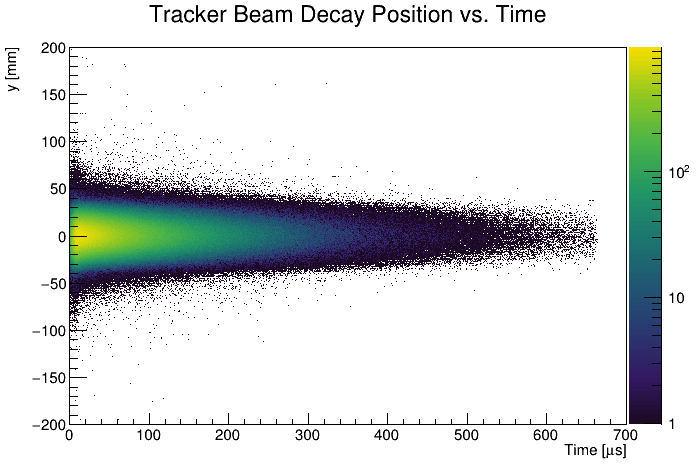

In [8]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time; Time [#mus]; y [mm]")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Lets get the beam position vs. time for the selected station

In [9]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
trackerBeamPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [10]:
tlow = 10
thigh = 300
func,paramVec = fitfunc(0, [tlow,thigh],[0,17,0.00053,-0.001]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"],nFit=2)
allFitResults[name+"_beam"] = fitresult

Error: confidence intervals not properly defined


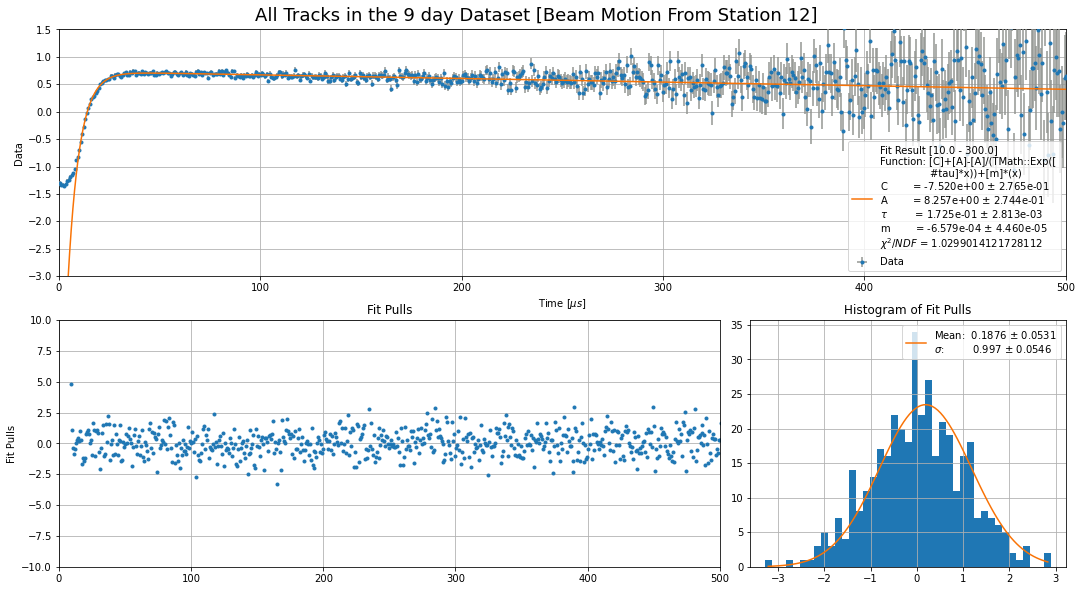

In [11]:
# fitresult.f.SetParameters(0,17,0.053,0)

fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(11,15)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_ylim(-3,1.5)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_Beam_"+dataset+".png", bbox_inches="tight")
plt.show()

/home/jlab/g-2/fitting/python_fit.py:435: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


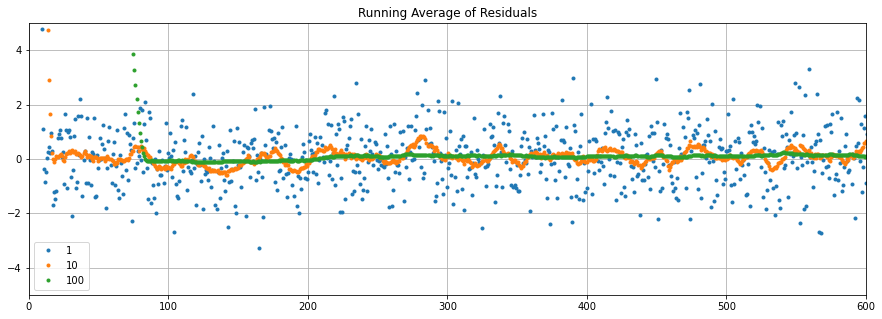

In [12]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(0,600)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [60, 300]


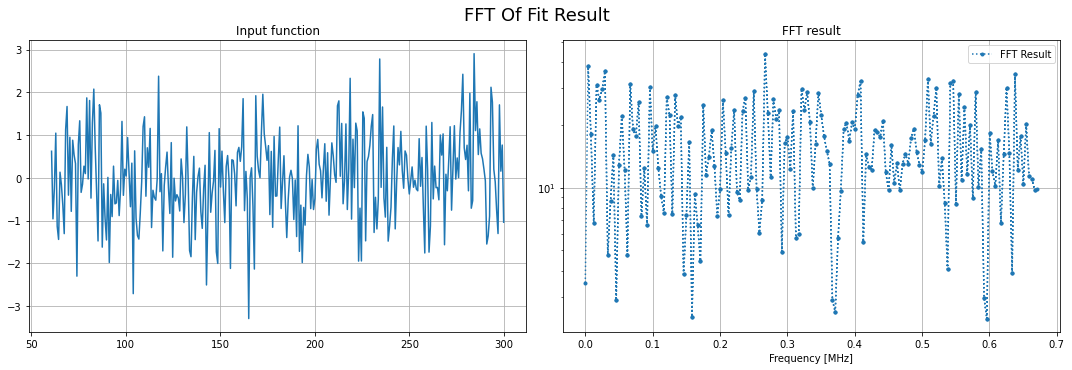

In [13]:
fitresult.fft([60,300],2)
plt.show()

---

### And the calo face position vs. time for the selected station

In [14]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
trackerCaloPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

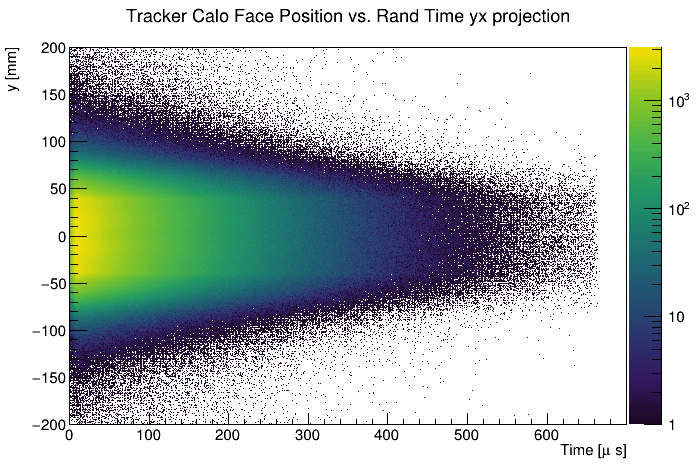

In [15]:
c = r.TCanvas()
hi = trackerCaloPos.Project3D("yx").Clone()
hi.Draw("colz")
c.SetLogz()
c.Draw()

In [16]:
tlow = 30
thigh = 550
func,paramVec = fitfunc(0, [tlow,thigh],[34, -3.5, 0.005, -0.005]) 
# func,paramVec = fitfunc(1, [tlow,thigh],[0,17,0.00053,-0.001]) 


fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

Error: confidence intervals not properly defined


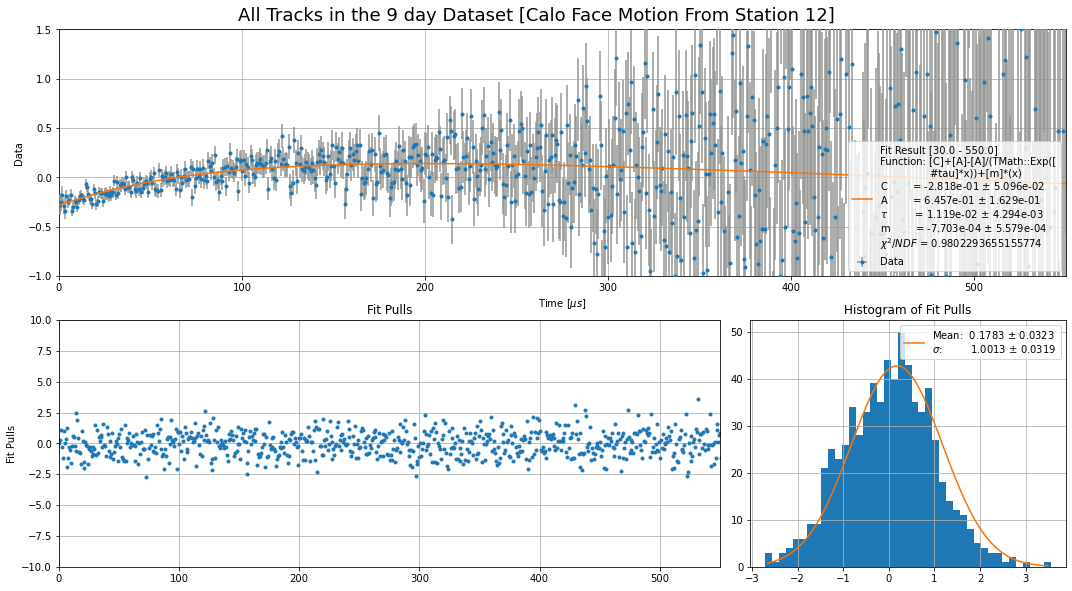

In [17]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(-1,1.5)
for i in range(2):
    ax[i].set_xlim(0,550)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

/home/jlab/g-2/fitting/python_fit.py:435: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


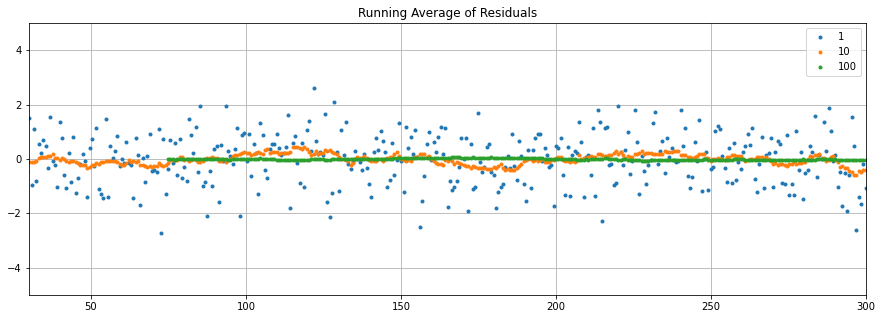

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


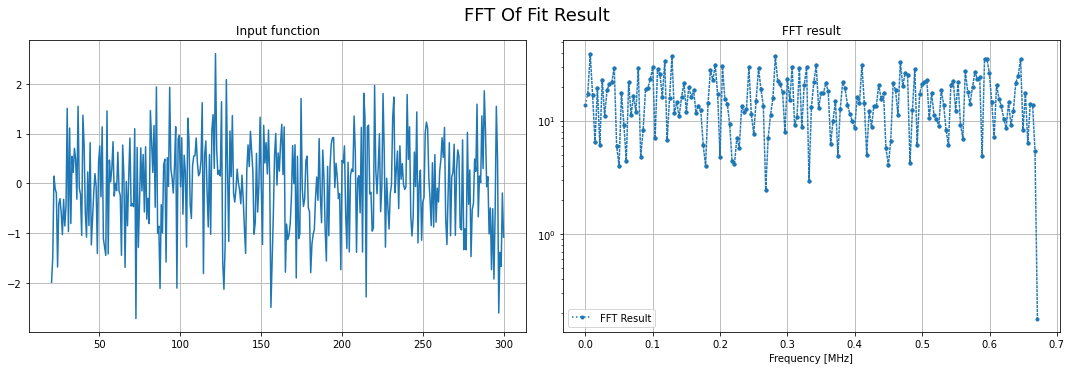

In [19]:
fitresult.fft([20,300],2)
plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [32]:
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
trackerCaloPos_noRadialFieldRand.GetYaxis().SetRangeUser(-75,75)
# trackerCaloPos_noRadialFieldRand.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

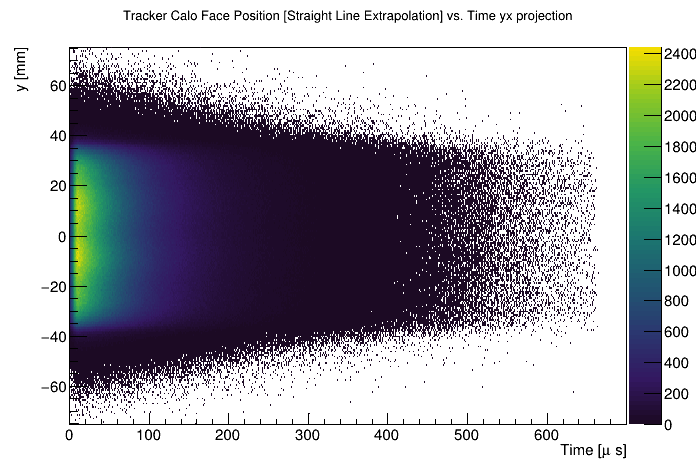

In [33]:
c = r.TCanvas()
trackerCaloPos_noRadialFieldRand.Project3D("yx").Draw("colz")
c.Draw()

In [34]:
tlow = 30
thigh = 350

func,paramVec = fitfunc(0, [tlow,thigh],[65, -3.5, 0.005, 0.005]) 
# func,paramVec = fitfunc(1, [tlow,thigh],[0,17,0.00053,-0.001]) 


fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

Error: confidence intervals not properly defined


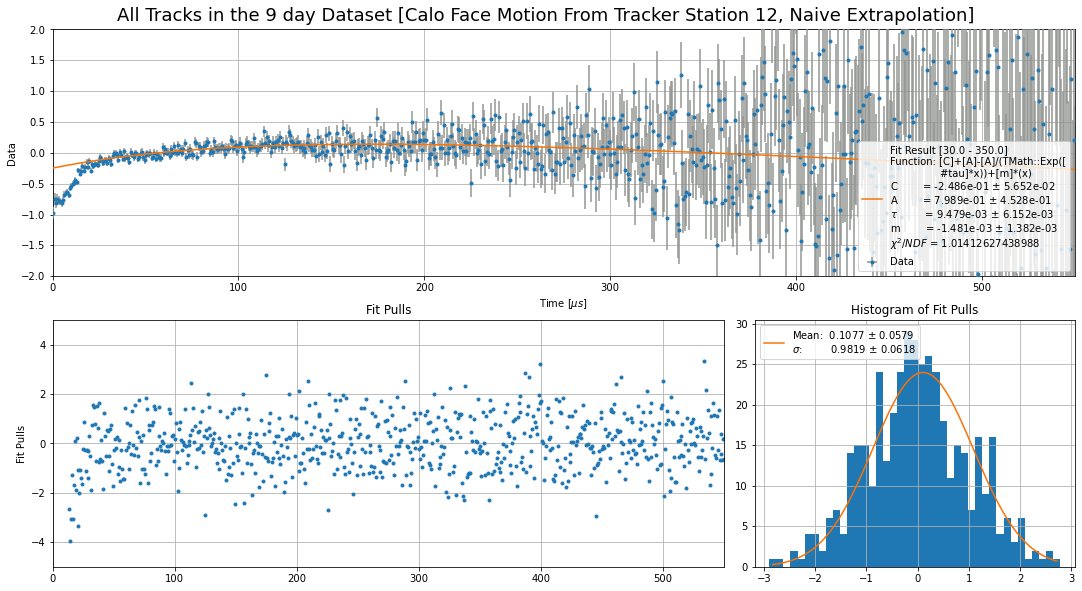

In [35]:
fig,ax = fitresult.draw(("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "
                         +str(station)+", Naive Extrapolation]"), 
                        yrange=[None, [-5,5]], fmti=".", do_pulls=True)
ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,550)
#ax[0].set_ylim(18,22)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

/home/jlab/g-2/fitting/python_fit.py:435: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


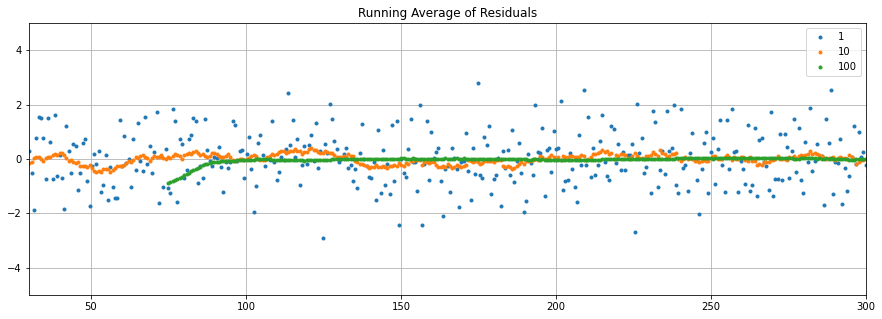

In [36]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


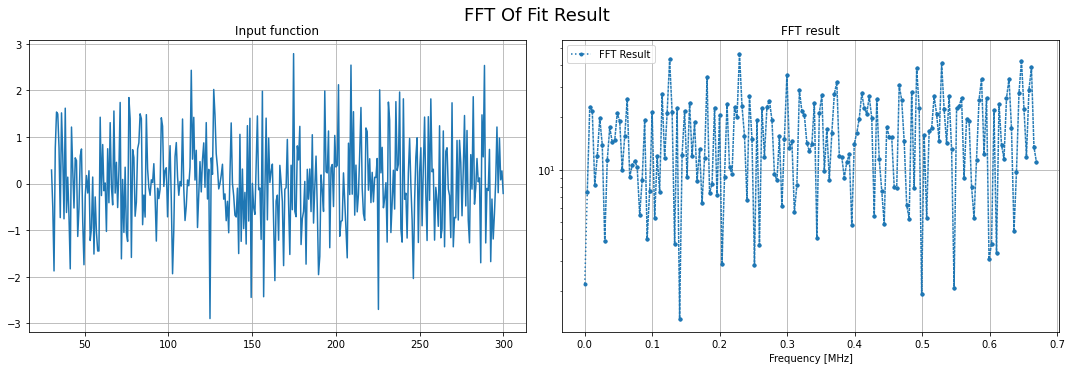

In [37]:
fitresult.fft([30,300],2)
plt.show()

---

### Difference in tracks vs time



In [38]:
trackerDeltaPosition_vs_Time = f.Get("trackerDeltaPosition_vs_Time").Clone()

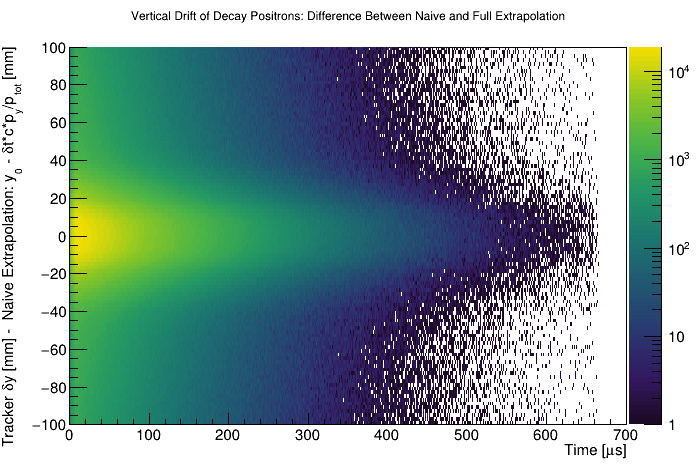

In [39]:
c = r.TCanvas()
trackerDeltaPosition_vs_Time.Draw("colz")
c.SetLogz()
c.Draw()

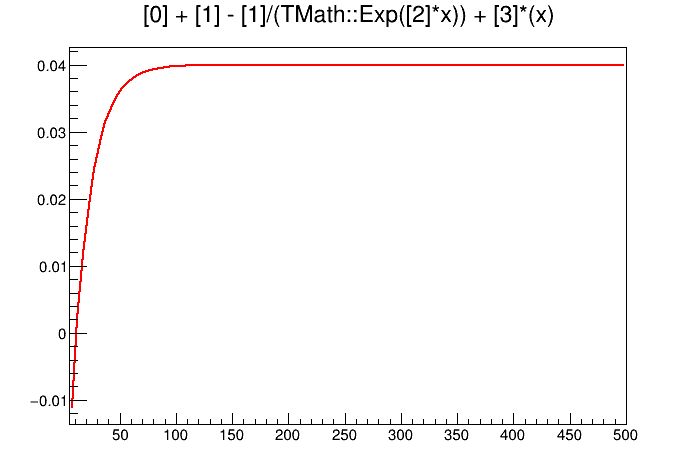

In [40]:
func = fitfunc(0,[5,500],[-0.04,0.08,0.06,0])[0]
func.Draw()
c.Draw()

Info in <TCanvas::Print>: png file ./images/outputFits/mean/AllTracks_Naive_Minus_Full_Extrapolation_9 day.png has been created


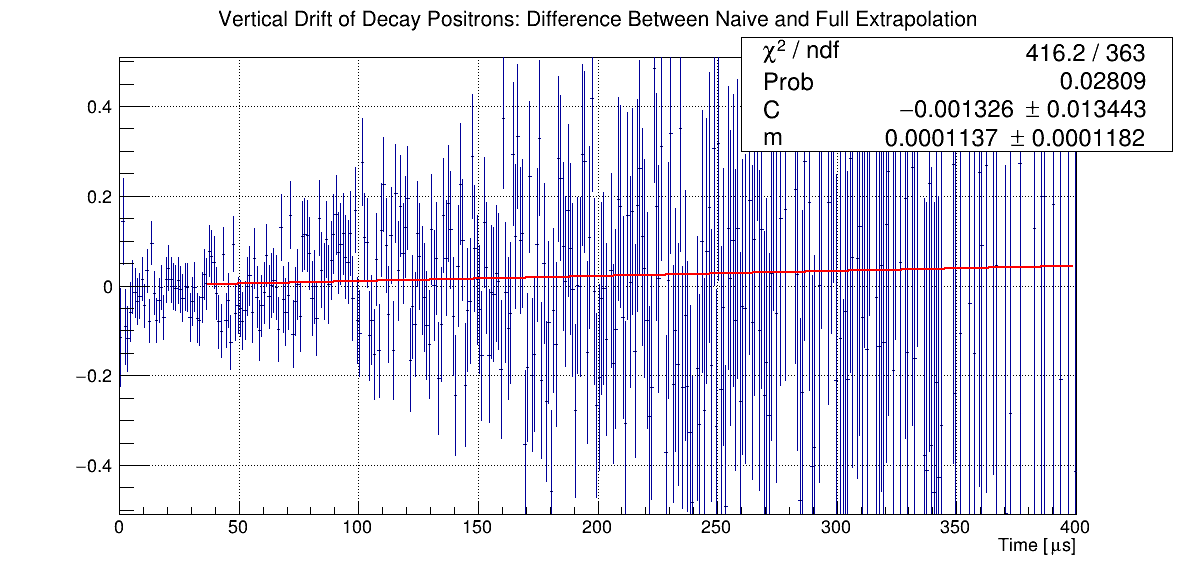

In [41]:
c = r.TCanvas("c","c",1200,600)
h2 = trackerDeltaPosition_vs_Time.ProfileX()
r.gStyle.SetOptFit(11111)
h2.Draw("")
func = fitfunc(1,[35,400],[-0.04,0.08,0.06,0])[0]
for i in range(2):
    h2.Fit(func,"REMBQ")
func.Draw("same")
h2.GetYaxis().SetRangeUser(-0.51,0.51)
h2.GetXaxis().SetRangeUser(0,400)
c.SetLogz()
c.SetGrid()
c.Print("./images/outputFits/"+to_fit+"/AllTracks_Naive_Minus_Full_Extrapolation_"+dataset+".png")
c.Draw()

---

# And now the calo only information

In [42]:
name = 'clusters'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/9day/clusters_9day.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/9day/clusters_9day.root	
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x5624df9945c0
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x5624df997e60
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x5624df9b4810
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x5624dfb7e430
  OBJ: TH1D		Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x5624dfb96bc0
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x5624e04e5310
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x5624e0509fe0
  OBJ: TH2D	trackerCaloPos_noRadialFieldRand_yx	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time yx project

In [43]:
clusters = f.Get("clusters"+str(calo)).Clone()
randclusters = f.Get("randclusters"+str(calo)).Clone()

ReferenceError: attempt to access a null-pointer

In [44]:
c = r.TCanvas()
randclusters.Project3D("zx").Draw("colz")
c.SetLogz()
c.Draw()

NameError: name 'randclusters' is not defined

---
### Calo face position

In [45]:
randclusters.GetYaxis().SetRange(randclusters.GetYaxis().FindBin(1000),randclusters.GetYaxis().FindBin(2400))
#randclusters.Rebin3D(5,1,1)
widthDict = getWidths(randclusters.Project3D("zx"), scale=25, offset=3)

NameError: name 'randclusters' is not defined

In [46]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

Error: confidence intervals not properly defined


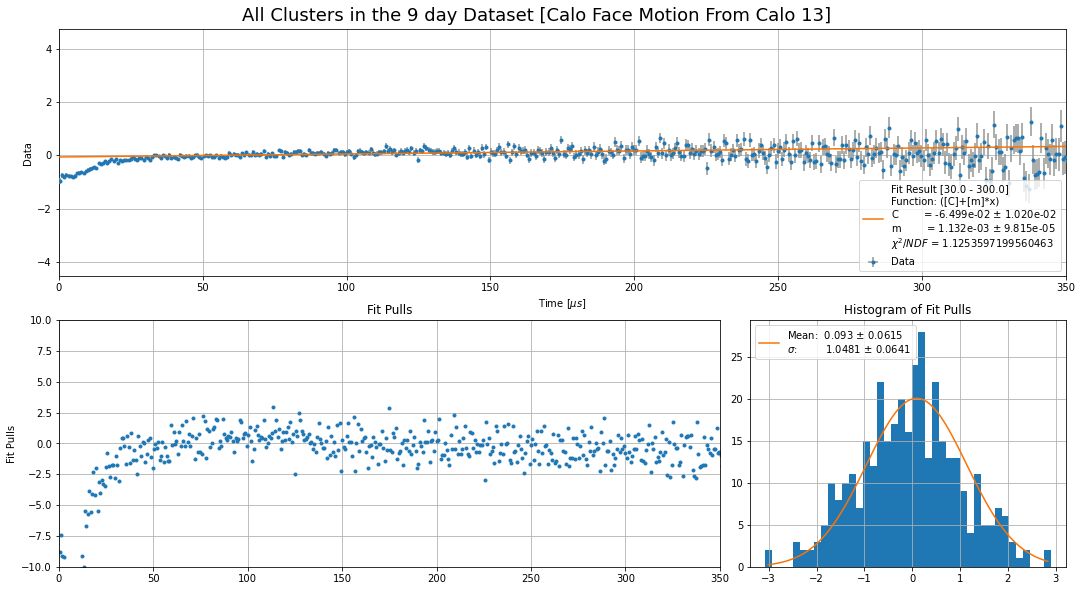

In [47]:
fig,ax = fitresult.draw("All Clusters in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,30)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,350)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllClusters_"+dataset+".png", bbox_inches="tight")

plt.show()

/home/jlab/g-2/fitting/python_fit.py:435: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


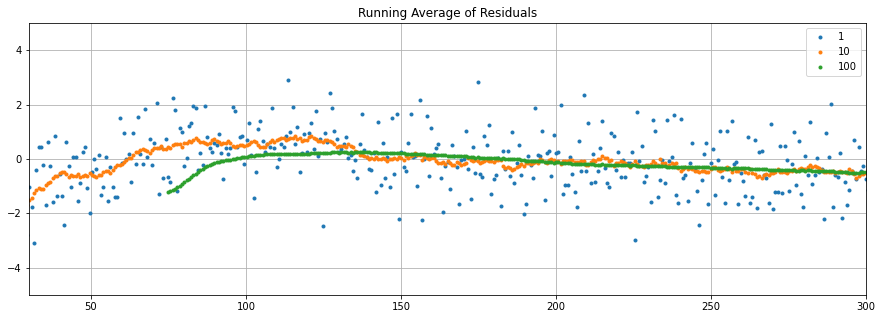

In [48]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


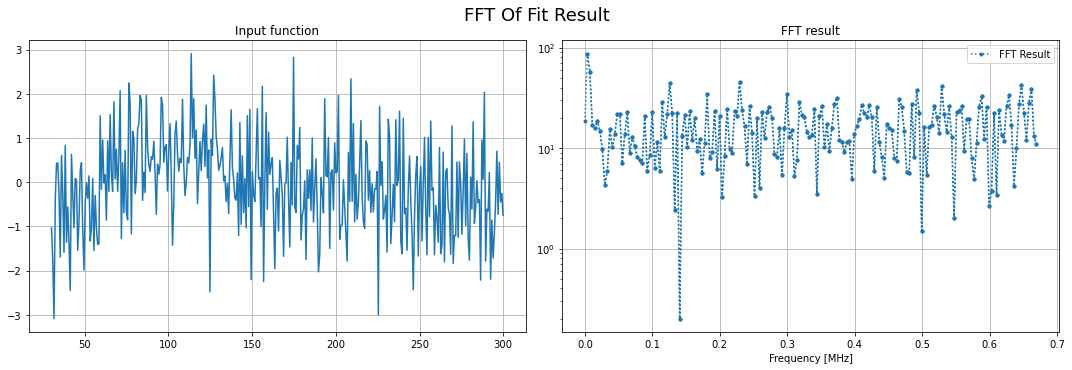

(array([ 0.        ,  0.00369776,  0.00739551,  0.01109327,  0.01479103,
         0.01848878,  0.02218654,  0.0258843 ,  0.02958205,  0.03327981,
         0.03697757,  0.04067532,  0.04437308,  0.04807084,  0.0517686 ,
         0.05546635,  0.05916411,  0.06286187,  0.06655962,  0.07025738,
         0.07395514,  0.07765289,  0.08135065,  0.08504841,  0.08874616,
         0.09244392,  0.09614168,  0.09983943,  0.10353719,  0.10723495,
         0.1109327 ,  0.11463046,  0.11832822,  0.12202597,  0.12572373,
         0.12942149,  0.13311924,  0.136817  ,  0.14051476,  0.14421251,
         0.14791027,  0.15160803,  0.15530579,  0.15900354,  0.1627013 ,
         0.16639906,  0.17009681,  0.17379457,  0.17749233,  0.18119008,
         0.18488784,  0.1885856 ,  0.19228335,  0.19598111,  0.19967887,
         0.20337662,  0.20707438,  0.21077214,  0.21446989,  0.21816765,
         0.22186541,  0.22556316,  0.22926092,  0.23295868,  0.23665643,
         0.24035419,  0.24405195,  0.2477497 ,  0.2

In [49]:
fitresult.fft([30,300],2)

---

# And finally the calo-matched information

In [50]:
name = 'matchedTracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/9day/matchedTracks_9day.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/9day/matchedTracks_9day.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	caloCaloPos;1	Calo Face Position from Clusters vs. Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	caloCaloPosRand;1	Calo Face Position from Clusters vs. Rand Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time


In [51]:
trackerBeamPos_match = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos_match = f.Get("trackerCaloPosRand").Clone()
caloCaloPos_match = f.Get("caloCaloPosRand").Clone()
trackerCaloPos_noRadialField_match = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand_match = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

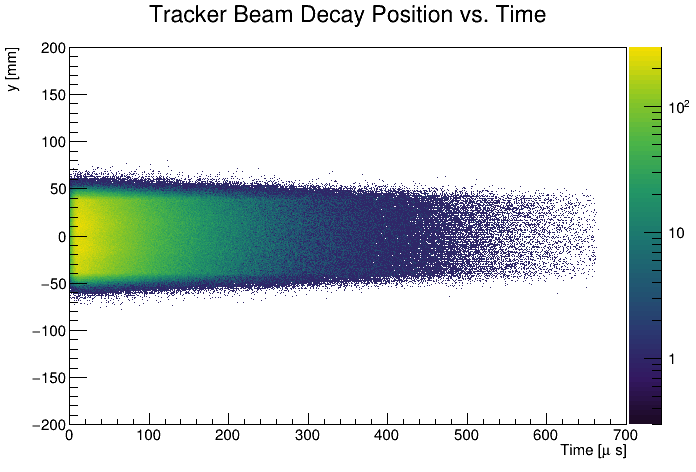

In [52]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))

hi = trackerBeamPos_match.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Beam position vs. time

In [53]:
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))
#trackerBeamPos_match.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos_match.Project3D("yx"))

In [54]:
tlow = 10
thigh = 300

# func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,-0.061])
func,paramVec = fitfunc(0, [tlow,thigh],[0,17,0.00053,-0.001]) 


fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_beam"] = fitresult

Error: confidence intervals not properly defined


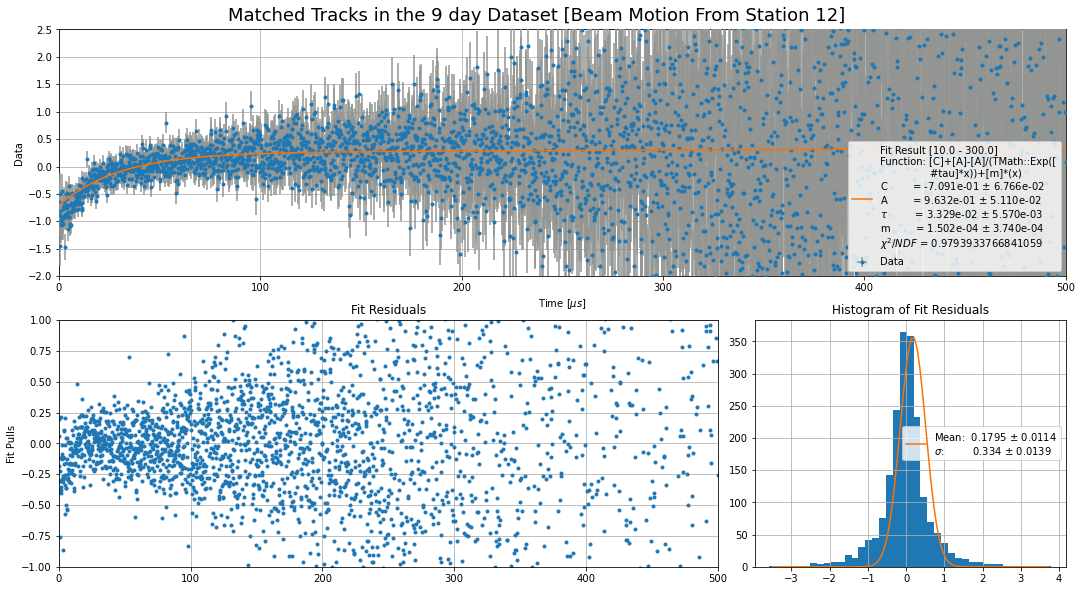

In [55]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-1,1]], fmti=".", do_pulls=False)
ax[0].set_ylim(-2,2.5)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_BeamMotion_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker)

In [56]:
trackerCaloPos_match.GetZaxis().SetRange(trackerCaloPos_match.GetZaxis().FindBin(station),
                                         trackerCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_match.Project3D("yx"))

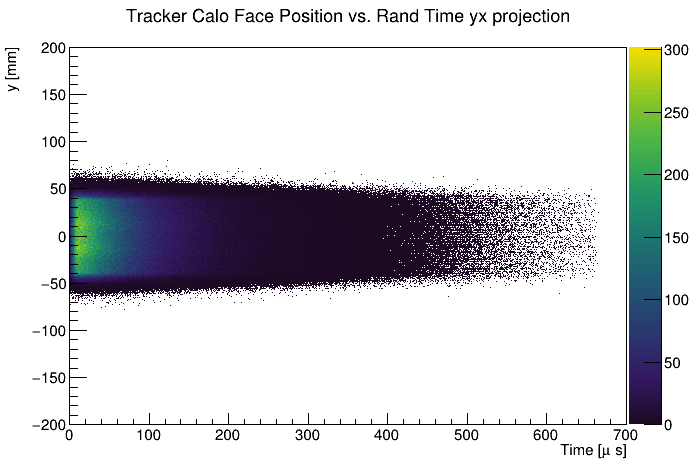

In [57]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_match.Project3D("yx").Draw("colz")
trackerCaloPos_match.SetTitle("Normal Extrapolation to Calo Face")
c.Draw()

In [58]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh],[35,-170,0.00053,-0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

Error: confidence intervals not properly defined


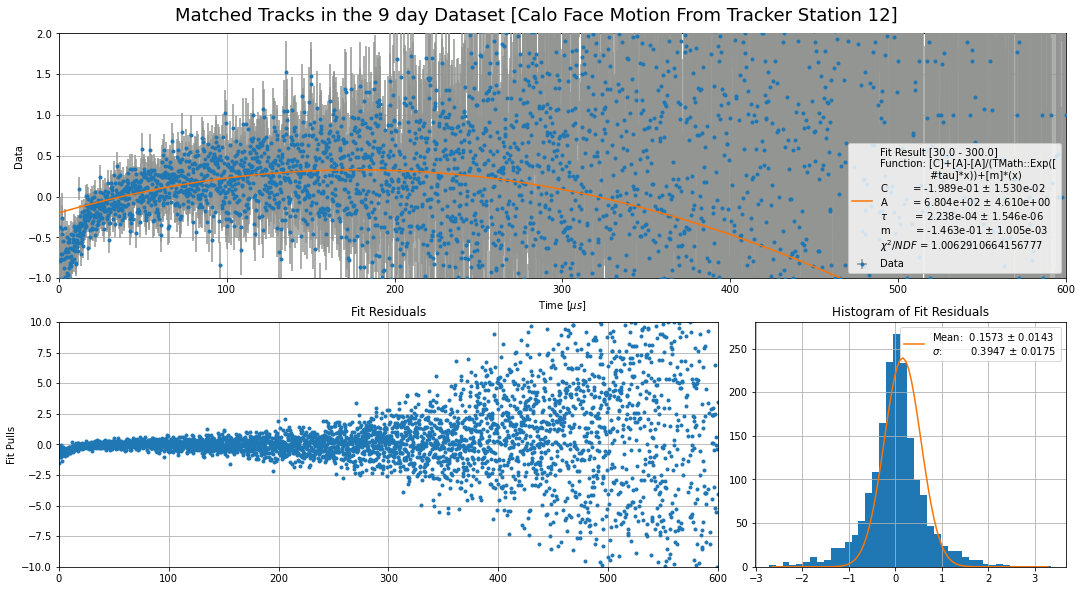

In [59]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+"]", 
                        yrange=[[-1,2], [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,600)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [60]:
trackerCaloPos_noRadialFieldRand_match.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand_match.Project3D("yx"))

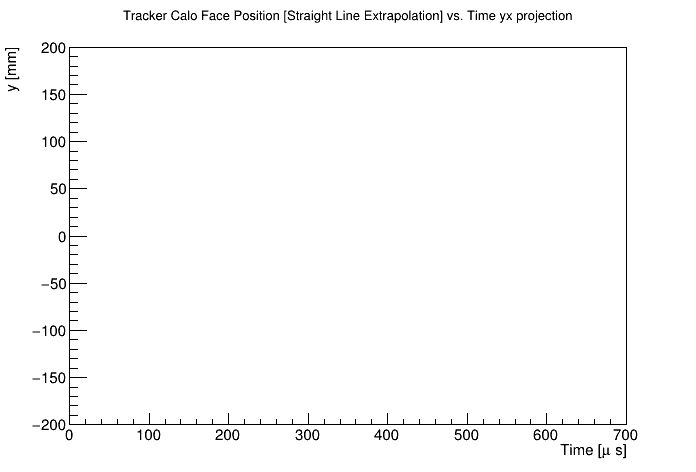

In [61]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_noRadialFieldRand_match.Project3D("yx").Draw("colz")
c.Draw()

In [62]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh], [-19, -3.5, 0.0005, 0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

Error: confidence intervals not properly defined


/home/jlab/g-2/fitting/python_fit.py:332: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymean - ystd*2, ymean + ystd*2)


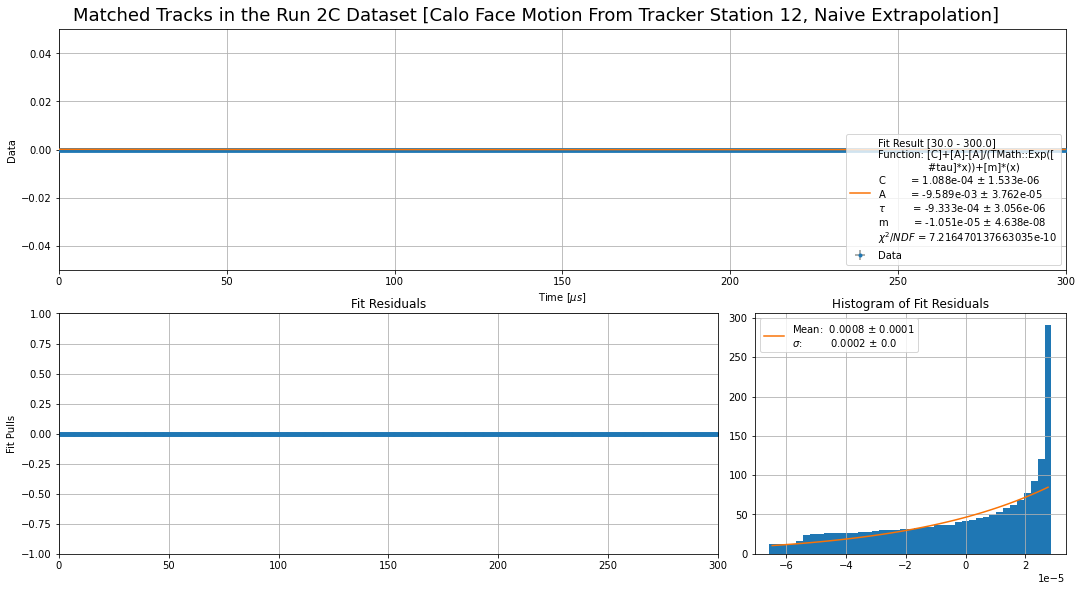

In [63]:
fig,ax = fitresult.draw("Matched Tracks in the Run 2C Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
# ax[0].set_ylim(18.5,20)
ax[1].set_ylim(-1,1)
for i in range(2):
    ax[i].set_xlim(0,300)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from clusters)

In [64]:
caloCaloPos_match.GetZaxis().SetRange(caloCaloPos_match.GetZaxis().FindBin(station),
                                      caloCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(caloCaloPos_match.Project3D("yx"))

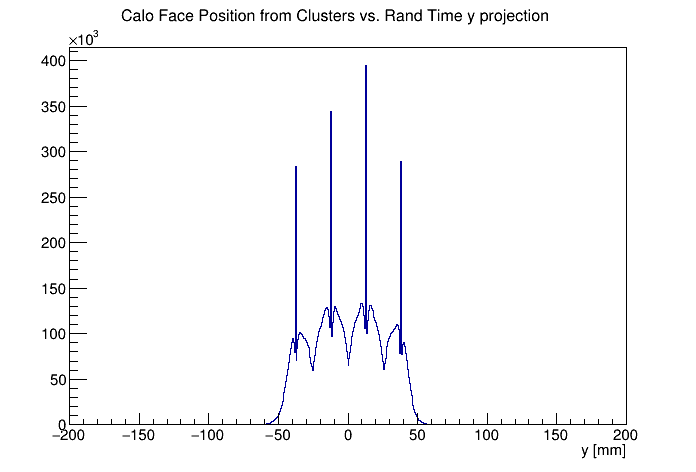

In [65]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
caloCaloPos_match.Project3D("y").Draw("colz")
c.Draw()

In [66]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_clusters"] = fitresult

Error: confidence intervals not properly defined


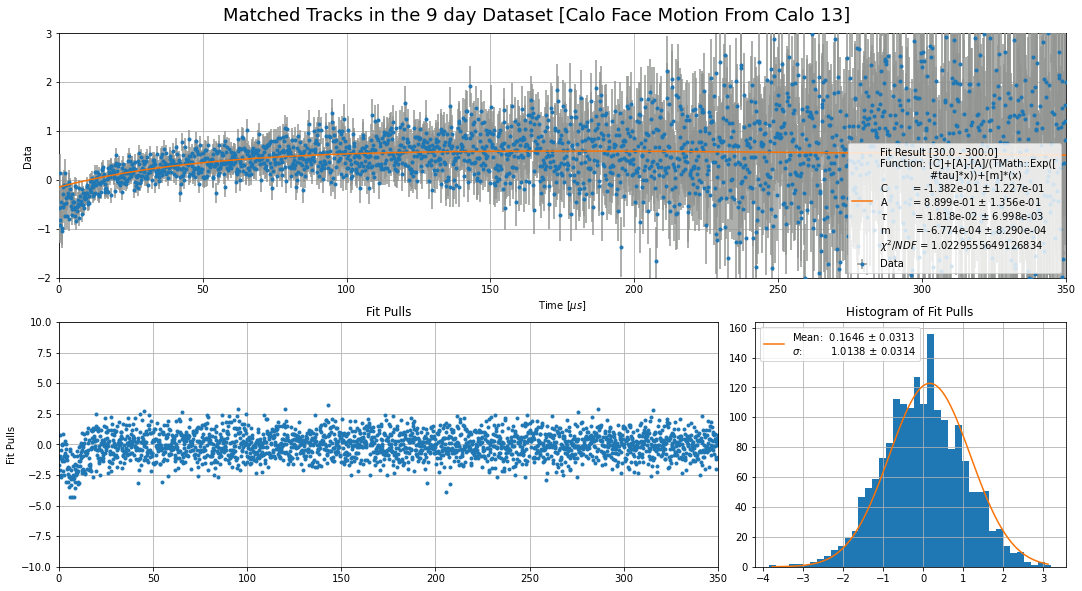

In [67]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[[-2,3], [-10,10]], fmti=".")
# ax[0].set_ylim(24,26)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,350)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_Clusters_"+dataset+".png", bbox_inches="tight")

plt.show()

---

# Now lets compare the fit results from these datasets

In [68]:
print(allFitResults)

{'tracks_beam': <python_fit.fitVector object at 0x7fd4002d7d10>, 'tracks_calo': <python_fit.fitVector object at 0x7fd41ae17e90>, 'tracks_calo_noRadialField': <python_fit.fitVector object at 0x7fd41b2b7650>, 'clusters_calo_noRadialField': <python_fit.fitVector object at 0x7fd41af73a50>, 'clusters_calo': <python_fit.fitVector object at 0x7fd41ada2810>, 'matchedTracks_beam': <python_fit.fitVector object at 0x7fd41aae0310>, 'matchedTracks_calo': <python_fit.fitVector object at 0x7fd41aa82390>, 'matchedTracks_calo_noRadialField': <python_fit.fitVector object at 0x7fd41a75ced0>, 'matchedTracks_clusters': <python_fit.fitVector object at 0x7fd41bdfe450>}


In [69]:
pars = []
parErrs = []
fitnames = []
allNames = []

for name,fit in allFitResults.items():
    print(name)
    fitnames.append(name)
    pars.append(fit.pars)
    parErrs.append(fit.parErrs)
    allNames.append( fit.parNames() )
print(allNames)

tracks_beam
tracks_calo
tracks_calo_noRadialField
clusters_calo_noRadialField
clusters_calo
matchedTracks_beam
matchedTracks_calo
matchedTracks_calo_noRadialField
matchedTracks_clusters
[['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm']]


In [70]:
parDict = {}
parErrDict = {}
histNames = {}
for names in allNames:
    for name in names:
        parDict[name] = []
        parErrDict[name] = []
        histNames[name] = []
for i, names in enumerate(allNames):
    for j, name in enumerate(names):
        parDict[name].append( pars[i][j] )
        parErrDict[name].append( parErrs[i][j] )
        histNames[name].append(fitnames[i])

In [71]:
print(parDict)
print(histNames)

{'C': [-7.5197612762948784, -0.2818118529722082, -0.5158923404061232, -0.24856546940679622, -0.06498597227094442, -0.7090726167074275, -0.1988556990321053, 0.00010878230356947509, -0.13824024853988306], 'A': [8.256521056355556, 0.6456603801609876, 1.4481851819346434, 0.7988795179140696, 0.963183826616888, 680.3834309937196, -0.009588671631217197, 0.8899494226527717], '$\\tau$ ': [0.17251398579516983, 0.011190814769270122, 0.006255808696357876, 0.009478747144557714, 0.033290528115602624, 0.00022382076728433964, -0.0009333378026528693, 0.018176865267427192], 'm': [-0.0006579341107641468, -0.00077032471783134, -0.0026935358081077313, -0.0014806817638741753, 0.0011324445851426364, 0.0001502308016708166, -0.14632919525152907, -1.0507432635461103e-05, -0.0006774114712548184]}
{'C': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'clusters_calo_noRadialField', 'clusters_calo', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField', 'matchedTracks_clusters']

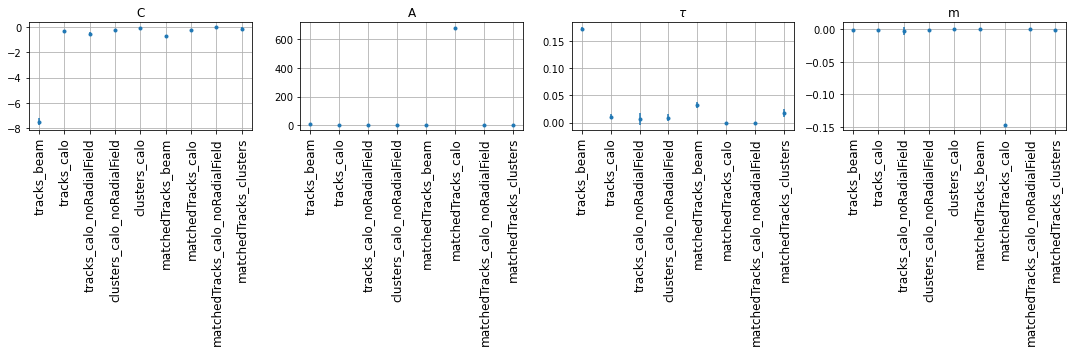

In [72]:
fig,axs = plt.subplots(1,4,figsize=(15,5), sharex=False)
ax = axs

for i, name in enumerate(parDict):
    axi = ax[i]
    thispar = parDict[name]
    axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt=".")
    axi.grid()
    axi.set_title(name)
    plt.sca(axi)
    plt.xticks(rotation=90, fontsize=12,)
plt.tight_layout()
plt.show()

C


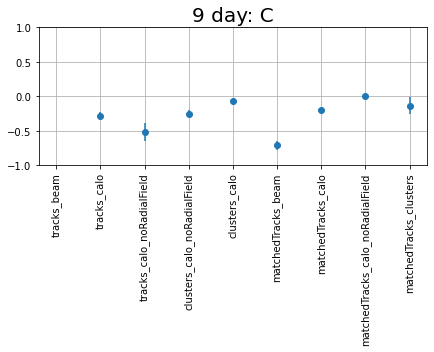

In [73]:
name = allNames[0][0]
print(name)
fig,ax = plt.subplots(figsize=(6,5))
axi = ax
thispar = parDict[name]
#axi.plot(histNames[name], thispar,".")
axi.errorbar(histNames[name], thispar, yerr=parErrDict[name], fmt="o")
axi.grid()
axi.set_title(dataset+": "+name,fontsize=20)
plt.sca(axi)
plt.xticks(rotation=90,)
plt.tight_layout()
plt.ylim(-1,1)
#plt.ylim(-0.015,0.025)
#plt.ylim(-0.02,0.04)
#plt.ylim(-0.015,0.025)
plt.show()

In [74]:
pars_byPar = [x for x in zip(*pars)]
parErrs_byPar = [x for x in zip(*parErrs)]

NameError: name 'parNames' is not defined

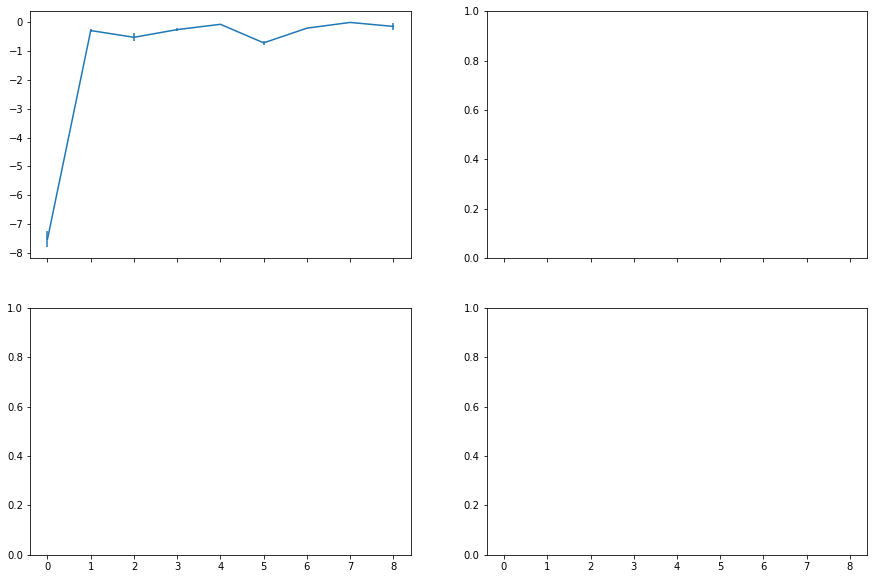

In [75]:
fig, axs = plt.subplots(int(len(pars[0])/2),2,figsize=(15,10), sharex=True)
if(len(pars[0]) > 2):
    ax = flatten2dArray(axs)
else:
    ax = axs
for i, axi in enumerate(ax):
    xpoints = [x for x in range(len(fitnames))]
    axi.errorbar(xpoints, pars_byPar[i], yerr=parErrs_byPar[i])
    axi.set_title(parNames[i])
    plt.sca(axi)
    plt.xticks(xpoints, labels=fitnames,rotation=90)
    axi.grid()
plt.tight_layout()
plt.suptitle("Parameters from All Fits: "+str(func.GetExpFormula()), y=1.03, fontsize=20)
plt.show()